## Boilerplate

In [1]:
%run initialize.ipynb

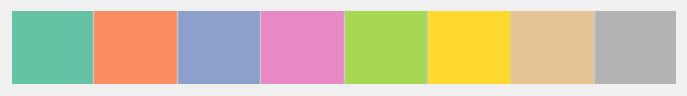

In [2]:
## custom rcParams settings for matplotlib
import sys
sys.path.append('../modeling-football-outcomes/config')
import mpl_style
colors = rcParams['axes.prop_cycle'].by_key()['color']

## Global Functions

In [3]:
def cast_dtypes(df):
    '''spark and numpy types don't play
    well together. cast as native python 
    types'''
    np_to_python_dtypes = {
        'int64': int,
        'float64': float,
        'object': str,
        'datetime64[ns]': str
    }

    for field, np_dtype in df.dtypes.to_dict().iteritems():
        df[field] = df[field].astype(np_to_python_dtypes[str(np_dtype)])
        
    return df

## Create __lines__ and __games__ DFs: load data and remove 2018 until it's complete

In [4]:
lines_df = pd.read_csv('all_lines.csv', index_col='Unnamed: 0')
games_df = pd.read_csv('game_metadata.csv')

In [5]:
lines_df = lines_df.rename(columns={'Season':'season'})
lines_df = lines_df[lines_df['season'] != 2018]
games_df = games_df[games_df['team0_link'].apply(lambda x: x.split('/')[-1].split('.')[0]) != '2018']

In [6]:
lines_df['season'].value_counts().sort_index()

2007    267
2008    267
2009    267
2010    267
2011    267
2012    267
2013    267
2014    267
2015    267
2016    267
2017    267
Name: season, dtype: int64

In [7]:
games_df['team0_link'].apply(lambda x: x.split('/')[-1].split('.')[0]).value_counts().sort_index()

2007    267
2008    267
2009    267
2010    267
2011    267
2012    267
2013    267
2014    267
2015    267
2016    267
2017    267
Name: team0_link, dtype: int64

In [8]:
lines_df.shape
games_df.shape

(2937, 26)

(2937, 23)

## Standardize Fields/Values Across Data Sources

### Error in raw data (__lines__ DF)
* 3 games have home/visiting teams switched (note: these are 3 Superbowls so the home/away don't match the official home and visiting teams. the home/visiting team is always "team0" in football-ref. there is an assertion confirms this below).
  * https://www.pro-football-reference.com/boxscores/201602070den.htm
  * https://www.pro-football-reference.com/boxscores/201502010sea.htm
  * https://www.pro-football-reference.com/boxscores/201302030sfo.htm

In [9]:
switches = lines_df[lines_df['Date'].apply(lambda x: x in ['2016-02-07','2015-02-01','2013-02-03'])]

In [10]:
col_val_switch = ['ML_Fav','Open_Fav','Close_Fav','2H_Fav']

for c in col_val_switch:
    switches.loc[:, c] = switches.loc[:, c].apply(lambda x: {'V':'H', 'H':'V', 'pickem': 'pickem'}[x])

## H --> X
## V --> H
## X --> V
h_to_x = dict([(c, c.replace('H_','X_')) for c in switches.columns if c.startswith('H_')])
switches.rename(
    columns=h_to_x, inplace=True
)
v_to_h = dict([(c, c.replace('V_','H_')) for c in switches.columns if c.startswith('V_')])
switches.rename(
    columns=v_to_h, inplace=True
)
x_to_v = dict([(c, c.replace('X_','V_')) for c in switches.columns if c.startswith('X_')])
switches.rename(
    columns=x_to_v, inplace=True
)

/Users/joshplotkin/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/joshplotkin/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [11]:
idx = switches.index
lines_df = lines_df.drop(idx)
lines_df = lines_df.append(switches)

/Users/joshplotkin/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [12]:
## Carolina, New England, and Baltimore should be home teams
lines_df[lines_df['Date'].apply(lambda x: x in ['2016-02-07','2015-02-01','2013-02-03'])].T

,1023,1290,1824
2H_Fav,H,H,V
2H_OU,22.5,pk,24.5
2H_Spread,4.5,24.5,7
Close_Fav,H,V,V
Close_OU,43.5,47.5,48
Close_Spread,5,0,4.5
Date,2016-02-07,2015-02-01,2013-02-03
H_Final,10,28,34
H_ML,-210,-110,170
H_Q1,0,0,7


### Dates (__lines__ and __games__ DFs)

In [13]:
lines_df['Date'] = lines_df['Date'].apply(pd.to_datetime)

games_df['day_of_week'] = games_df['date'].apply(pd.to_datetime).dt.dayofweek
games_df['date'] = games_df['date'].apply(pd.to_datetime)

### Team names (__lines__)

In [14]:
team_map = json.load(open('team_map_for_lines.json','r'))
for i, (k,v) in enumerate(team_map.iteritems()):
    print '{} --> {}'.format(k, v)
    if i == 5:
        break
        
for field in ['V_Team','H_Team']:
    lines_df[field] = lines_df[field].map(team_map)

Dallas --> Cowboys
NewYork --> Giants
NYGiants --> Giants
Minnesota --> Vikings
Denver --> Broncos
NewEngland --> Patriots


### Create __games_lines__: prepare and then join __games__ and __lines__
* key is (date, team first alphabetically)

In [15]:
## cast dtypes to Spark compatible using global function cast_dtypes
games_df = cast_dtypes(games_df)
lines_df = cast_dtypes(lines_df)

In [16]:
def gen_game_key(x):
    '''generates a key for each game:
    (first alphabetical team name, date)'''
    team_a, team_b, dt = x
    return (sorted([team_a, team_b])[0], dt)

games_key_fields = ['team0_name','team1_name','date']
lines_key_fields = ['H_Team','V_Team', 'Date']

games_df['key'] = games_df[games_key_fields].apply(gen_game_key, axis=1)
lines_df['key'] = lines_df[lines_key_fields].apply(gen_game_key, axis=1)

Note: week 16 2018 lines not yet available

In [17]:
a = set(games_df['key'].apply(lambda x: '_'.join(x)).values.tolist())
b = set(lines_df['key'].apply(lambda x: '_'.join(x)).values.tolist())

len(a - b)
a - b

0

set()

In [18]:
len(b-a)
b-a

0

set()

In [19]:
games_lines_df = games_df.merge(
        lines_df, left_on='key', right_on='key'
    ).drop(
        lines_key_fields + ['key'], axis=1
    )

## ensure there are no join misses
lines_df.shape[0], games_df.shape[0], games_lines_df.shape[0]
assert lines_df.shape[0] == games_df.shape[0]
assert games_lines_df.shape[0] == games_df.shape[0]

(2937, 2937, 2937)

## Create __game_info__: load PFR game_info files
* contains metadata like turf and weather

In [20]:
## get the path for each game_info csv
game_info_csvs = map(
    lambda x: 'game_info/{}'.format(x), 
    os.listdir('game_info')
)
## read each game_info csv into pandas
game_info_dfs = map(
    lambda x: pd.read_csv(x, index_col='Unnamed: 0'), 
    game_info_csvs
)
## union all the DFs
game_info_df = reduce(
    lambda x,y: x.append(y).reset_index(drop=True), 
    game_info_dfs
)

In [21]:
for c in game_info_df.columns:
    game_info_df[c] = game_info_df[c].str.strip()

In [22]:
game_info_df.head()

,game_id,info,stat
0,201812090was,Won Toss,Giants (deferred)
1,201812090was,Roof,outdoors
2,201812090was,Surface,grass
3,201812090was,Weather,"33 degrees, wind 6 mph"
4,201812090was,Vegas Line,New York Giants -3.0


In [23]:
game_info_df['key_value'] = game_info_df[['info','stat']].apply(
    lambda (k,v): {k:v}, axis=1
)

game_info_dict = {}
for game in game_info_df['game_id'].unique():
    curr_game_df = game_info_df[game_info_df['game_id'] == game]
    game_info_dict[game] = {
            d.keys()[0]:d.values()[0] 
            for d in curr_game_df['key_value'].values
        }

In [24]:
game_info_colnames = {
    'Vegas Line': 'pfr_line',
    'Over/Under': 'pfr_ou',
    'Weather': 'prf_weather',
    'Roof': 'roof',
    'Surface': 'surface'
}

game_info = pd.DataFrame.from_dict(game_info_dict, orient='index')\
                .rename(columns=game_info_colnames)\
                .drop(['Won Toss','Won OT Toss','Super Bowl MVP'], axis=1)

In [25]:
game_info.head().T

,200709060clt,200709090buf,200709090cle,200709090dal,200709090gnb
surface,fieldturf,astroplay,grass,fieldturf,grass
pfr_line,Indianapolis Colts -5.5,Denver Broncos -3.0,Pittsburgh Steelers -4.5,Dallas Cowboys -6.5,Philadelphia Eagles -3.0
pfr_ou,53.5 (under),37.0 (under),36.5 (over),44.5 (over),42.5 (under)
roof,dome,outdoors,outdoors,outdoors,outdoors
prf_weather,NaN,"70 degrees relative humidity 93%, wind 5 mph, ...","71 degrees relative humidity 80%, wind 5 mph, ...","78 degrees relative humidity 85%, no wind, win...","62 degrees relative humidity 80%, wind 9 mph, ..."


## Create __games_lines_info__: join __games_lines__ with __game_info__ assert there are no join misses

In [26]:
## 2018 games
diffs = set(game_info.index.tolist()) - set(games_lines_df['game_id'].tolist())
set(map(lambda x: x[:4], diffs))

games_lines_info = games_lines_df.merge(game_info, left_on='game_id', right_index=True)

games_lines_df.shape[0], game_info.shape[0], games_lines_info.shape[0]

{'2018'}

(2937, 3177, 2937)

In [27]:
## TEMPORARILY TURNING OFF
# assert games_lines_df.shape[0] == game_info.shape[0]
# assert games_lines_df.shape[0] == games_lines_info.shape[0]

## Enrich __games_lines_info__

### Stadium lat/long and timezone
* for each stadium
* to be used for computing travel

In [28]:
stadiums = pd.read_csv('stadiums_w_tz.csv')

## assert that stadiums lat/long csv has all stadiums in the games_df
assert not set(games_lines_info['stadium'].unique()) - set(stadiums['stadium'].unique())
before = games_lines_info.shape[0]
games_lines_info = games_lines_info.merge(
        stadiums, left_on='stadium', right_on='stadium'
    )

assert games_lines_info.shape[0] == before

In [29]:
games_lines_info[stadiums.columns].drop_duplicates().head(10)

,stadium,lat,long,timezone
0,RCA Dome,39.76361,-86.16333,-5.0
9,Ralph Wilson Stadium,42.77400,-78.78700,-5.0
74,Cleveland Browns Stadium,41.50611,-81.69944,-5.0
122,Texas Stadium,32.84000,-96.91100,-6.0
139,Lambeau Field,44.50139,-88.06222,-6.0
234,Reliant Stadium,29.68472,-95.41083,-6.0
292,Jacksonville Municipal Stadium,30.32389,-81.63750,-5.0
316,Hubert H. Humphrey Metrodome,44.97389,-93.25806,-6.0
342,Giants Stadium,40.81222,-74.07694,-5.0
391,McAfee Coliseum,37.75167,-122.20056,-8.0


### Load __gamelogs__ and use it to add in the week number
* #### Future TODO: incorporate gamelogs data as needed, e.g. game stats

In [30]:
gamelogs = pd.read_csv('gamelogs.csv')

#### Temp: remove 2018

In [31]:
gamelogs = gamelogs[gamelogs['season'] < 2018]

In [32]:
game_time_info = gamelogs[['game_id','season','week_id']].drop_duplicates() 

In [33]:
game_time_info.head()

,game_id,season,week_id
0,200909130clt,2009,1
1,200909200jax,2009,2
2,200909270htx,2009,3
3,200910040jax,2009,4
4,200910110sea,2009,5


In [34]:
assert games_lines_info.shape[0] == games_lines_info.merge(
        game_time_info, left_on='game_id', right_on='game_id'
    ).shape[0]

In [35]:
games_lines_tz = games_lines_info.drop(
        'season', axis=1
    ).merge(
        game_time_info, left_on='game_id', right_on='game_id'
    )

In [36]:
## assert each season has the same number of games (267)
tmp = games_lines_tz['season'].value_counts().sort_index()
assert tmp.max() == tmp.min()

tmp = games_lines_tz[['season','week_id','team0_link']].rename(
        columns={'team0_link':'team'}
    ).append(
        games_lines_tz[['season','week_id','team1_link']].rename(
            columns={'team1_link':'team'}
        )
    ).reset_index(drop=True)

## assert each team has 16 games each season in gamelog
assert (tmp[tmp['week_id'] <= 17].groupby(['team','season']).size() == 16).all()

### assert that no one plays >1 game in a week
assert (tmp[tmp['week_id'] <= 17].groupby(['team','season','week_id']).size() == 1).all()

### Infer stadium --> home team (or neutral)
* TODO: clean this up
* PFR has team0 == home team (including official "home" team in neutral stadiums)
* treat jets vs. giants as both home (neutral)

In [ ]:
## get a count of team games plabyed by stadium
tmp = games_lines_tz.copy()
tmp['teams'] = tmp[['team0_link','team1_link']].apply(
    lambda x: map(lambda y: y.split('/')[2], x), 
    axis=1
)
stad = spark.createDataFrame(
        tmp[['teams','stadium','season']]
    ).select(
        F.explode('teams').alias('team'), 'stadium', 'season'
    ).groupby('stadium','season','team').count()\
     .groupby('stadium','season').pivot('team').agg(F.sum('count')).toPandas().fillna(0)

In [ ]:
## compute the proportion of a stadium's games that each team played
## **assumption used: of a stadium has had more thna 6 games played
## and a team has >20% of games played there, that is the home team
## TODO: make this more elegant, maybe leveraging the Wiki package
key = ['stadium','season']
teams = list(set(stad.columns) - set(key))

stad['sum'] = stad[teams].sum(axis=1)

for t in teams:
    stad[t] /= stad['sum']
    
def find_home_team(props, teams):
    props, ngames = (props[:-1], props[-1])
    max_idx = [
        i for (i, t) in enumerate(props) 
        if (t > 0.2) & (ngames > 6)
    ]
    return map(lambda t: teams[t], max_idx)

stad['home_teams'] = stad[teams + ['sum']].apply(
    lambda x: find_home_team(x, teams), axis=1
)

In [ ]:
# SPECIAL CASES (games relocated nearby)
## set Rogers Centre to buf
rog = stad[stad['stadium'] == 'Rogers Centre'].index
stad.loc[rog, 'home_teams'] = stad.loc[rog, 'season'].apply(lambda x: ['buf'])
stad.loc[rog, :]

## set TCF Bank Stadium to min
tcf = stad[stad['stadium'] == 'TCF Bank Stadium'].index
stad.loc[tcf, 'home_teams'] = stad.loc[tcf, 'season'].apply(lambda x: ['min'])
stad.loc[tcf, :]

In [ ]:
stad[['stadium','season','home_teams']].sort_values(by=['stadium','season']).head()

In [ ]:
## take the previous DF, and tack on the 
## list of home teams
games_lines_info_homeaway = games_lines_tz.merge(
    stad[['stadium','season','home_teams']],
    left_on=['stadium','season'],
    right_on=['stadium','season']
)
assert games_lines_info_homeaway.shape[0] == games_lines_tz.shape[0]

In [ ]:
games_lines_info_homeaway['team0'] = games_lines_info_homeaway['team0_link'].apply(lambda x: x.split('/')[2])
games_lines_info_homeaway['team1'] = games_lines_info_homeaway['team1_link'].apply(lambda x: x.split('/')[2])

games_lines_info_homeaway['team0_home_unof'] = games_lines_info_homeaway[['team0','home_teams']].apply(
    lambda x: x[0] in x[1],
    axis=1
)
games_lines_info_homeaway['team1_home_unof'] = games_lines_info_homeaway[['team1','home_teams']].apply(
    lambda x: x[0] in x[1],
    axis=1
)

In [ ]:
def extract_home_team(x):
    team0, team1 = x
    if team0 == team1:
        return 'neutral'
    elif team0 is True:
        return 'team0'
    elif team1 is True:
        return 'team1'
    
games_lines_info_homeaway['home_team'] = games_lines_info_homeaway.loc[
        :, ['team0_home_unof','team1_home_unof']
    ].apply(
        extract_home_team, axis=1
    )
games_lines_info_homeaway.drop(
    ['team0_home_unof','team1_home_unof'], axis=1, inplace=True
)
games_lines_info_homeaway.rename(
    columns={'home_teams':'stadium_home_team'}, inplace=True
)

games_lines_info_homeaway['home_team'].value_counts()

In [ ]:
## replace team0 with the team0 name
team0_idx = games_lines_info_homeaway[
                games_lines_info_homeaway['home_team'] == 'team0'
            ].index.tolist()

games_lines_info_homeaway.loc[team0_idx, 'home_team'] = games_lines_info_homeaway\
                                                            .loc[team0_idx, 'team0']

In [ ]:
## still 39 neutral
games_lines_info_homeaway['home_team'].value_counts().tail()

In [ ]:
assert games_lines_info_homeaway[
    (games_lines_info_homeaway['home_team'] == 'neutral')
    & (games_lines_info_homeaway[['H_Q1','H_Q2','H_Q3','H_Q4']].sum(axis=1) 
          != games_lines_info_homeaway['team0_score'])
    & (games_lines_info_homeaway[['V_Q1','V_Q2','V_Q3','V_Q4']].sum(axis=1) 
          != games_lines_info_homeaway['team1_score'])
].shape[0] == 0

In [ ]:
games_lines_info_homeaway['H_score_calc'] = games_lines_info_homeaway\
                                        [['H_Q1','H_Q2','H_Q3','H_Q4']].sum(axis=1)
games_lines_info_homeaway['V_score_calc'] = games_lines_info_homeaway\
                                        [['V_Q1','V_Q2','V_Q3','V_Q4']].sum(axis=1)

games_lines_info_homeaway[
        games_lines_info_homeaway['home_team'] == 'neutral'
    ].loc[:, ['game_id','team0','team1','stadium','H_score_calc',
              'team0_score','V_score_calc','team1_score',
              'stadium_home_team']
    ].sort_values(by='stadium').head(10)
                                 
games_lines_info_homeaway.drop(['H_score_calc','V_score_calc'], axis=1, inplace=True)

#### another method for home teams

In [ ]:
home_teams = gamelogs[['game_id','game_location','game_loc_team_ref']]
loc_neutral = home_teams[home_teams['game_location'] == 'N']\
                    .loc[:, ['game_location','game_id']]\
                    .drop_duplicates()\
                    .set_index('game_id')
loc_neutral['game_loc_team_ref'] = None

loc_home = home_teams[home_teams['game_location'].isnull()]\
                    .set_index('game_id')
loc_all = loc_home.append(loc_neutral).reset_index()

In [ ]:
loc_all['home_team_src'] = loc_all[['game_location','game_loc_team_ref']].apply(
    lambda x: x[1] if x[0] != 'N' else None,
    axis=1
)
loc_all = loc_all[['game_id','home_team_src']]

In [ ]:
assert games_lines_info_homeaway.shape[0] == games_lines_info_homeaway.merge(
        loc_all, left_on='game_id', right_on='game_id'
    ).shape[0]

games_lines_info_homeaway = games_lines_info_homeaway.merge(
        loc_all, left_on='game_id', right_on='game_id'
    )

#### home team sanity check
* home teams mismatch only in games originally tagged as neutral
* this includes games in Wembley, 
* result
  * satisfied with the original tagging
  * the official tagging in neutral games is unnecessary
  * leaving UK/Mexico games, Jets vs. Giants games, and moved games as neutral

In [ ]:
mismatches = games_lines_info_homeaway[
    games_lines_info_homeaway[['home_team','home_team_src']].apply(
        lambda x: x[0] != x[1], 
        axis=1
    )][['team0_fullname','team1_fullname','stadium','home_team',
     'home_team_src','game_id','stadium_home_team']]

print 'SUPER BOWLS'
mismatches[
    (mismatches['home_team'] == 'neutral')
    & (mismatches['home_team_src'].apply(lambda x: x is None))
]

print 'GAMES TAGGED AS NEUTRAL'
mismatches[
    (mismatches['home_team_src'].apply(lambda x: x is not None))
].sort_values(by='stadium')

In [ ]:
games_lines_info_homeaway.drop('home_team_src', axis=1, inplace=True)

### Divisions

In [ ]:
divisions_df = pd.read_csv('team_divisions.csv', index_col='idx')

In [ ]:
before = games_lines_info_homeaway.shape[0]
for nteam in [0,1]:
    games_lines_info_homeaway = games_lines_info_homeaway.merge(
        divisions_df.rename(
            columns={'division': 'team{}_division'.format(nteam)}
        ),
        left_on=['season','team{}_fullname'.format(nteam)],
        right_on=['season','team']
    ).drop('team', axis=1)
    assert games_lines_info_homeaway.shape[0] == before

### Re-order columns

In [ ]:
def reorder_cols(df, front_cols):
    '''takes a DF and list of columns 
    to move to the front (in order).
    returns DF'''
    return df[
        front_cols 
        + filter(
            lambda x: x not in front_cols, 
            df.columns
        )]
    
front_cols = ['game_id','season','week_id']
base_df = reorder_cols(games_lines_info_homeaway, front_cols)

## Write Hive Table: __games_denorm__

### Clean up column names
* make all columns lowercase
* change all team0 --> h, team1 --> v

In [ ]:
## make columns all lowercase
base_df.columns = map(lambda x: x.lower(), base_df.columns)

## rename team0 and team1 to h and v, respectively
team_fields = filter(
    lambda x: x.startswith('team0_') or x.startswith('team1_'), 
    base_df.columns
)

team_field_rename = dict(
    map(
        lambda x: (x, x.replace('team0_','h_').replace('team1_','v_')), 
        team_fields
    )
)

## modify team IDs to match the same convention
team_field_rename['team0'] = 'h_team_id'
team_field_rename['team1'] = 'v_team_id'

## execute name changes
base_df.rename(columns=team_field_rename, inplace=True)

## don't need coach_raw (PFR link)
base_df = base_df.drop(['h_coach_raw','v_coach_raw'], axis=1)

In [ ]:
print 'RENAMING'
for k in sorted(team_field_rename.keys()):
    print '{}\t->\t{}'.format(k, team_field_rename[k])

In [ ]:
spark.createDataFrame(
        cast_dtypes(
            base_df
        )
    ).write.mode('overwrite').saveAsTable('games_denorm')

## Create Denormalized Schema and Write Hive Tables

In [ ]:
## union h and v fields and get distinct values
def combine_h_v(full_df, all_fields, non_team_fields):
    '''given a DataFrame with 2 teams:
    * split into 2 DFs by h and v
    * rename and align schemas
    * union
    * drop duplicates
    * return a DataFrame to be converted into Hive table'''
    for team_i in ['h','v']:
        prefix = '{}_'.format(team_i)
        fields = [
            a for a in all_fields
            if a.startswith(prefix)
        ]
        curr_table = full_df[non_team_fields + fields]
        ## team out team0 and team1 to align schemas
        field_map = dict(map(
                lambda x: ( x, '_'.join(x.split('_')[1:]) ), 
                fields
            ))
        curr_table = curr_table.rename(columns=field_map)

        if team_i == 'h':
            curr_df = curr_table
        else:
            curr_df = curr_df.append(
                curr_table[curr_df.columns]
            ).reset_index(drop=True)

    return curr_df.drop_duplicates()

### __team_season__
* #### primary key: (season, team_id)
* #### foreign key: team_id --> game(season, h_team_id)
* #### foreign key: team_id --> game(season, v_team_id)

In [ ]:
key = ['season','team_id']
team_season_fields = [
    'season',
    'h_team_id','h_link','h_name','h_fullname','h_city','h_division',
    'v_team_id','v_link','v_name','v_fullname','v_city','v_division'
]

team_season_df = combine_h_v(base_df.copy(), team_season_fields, ['season'])

## assert that every season has the same amount of teams
assert team_season_df['season'].value_counts().min() \
        == team_season_df['season'].value_counts().max()

## assert key (season, link) is unique
assert team_season_df.groupby(key).size().max() == 1
for h_v in ['h','v']:
    fkey = ['season','{}_team_id'.format(h_v)]
    assert base_df.shape[0] == base_df[fkey].merge(
                                        team_season_df, left_on=fkey, 
                                        right_on=key
                                    ).shape[0]


team_season_df.head()

In [ ]:
team_season_df['name'].value_counts().shape[0]
team_season_df['season'].value_counts()

In [ ]:
team_season_df.shape[0]
team_season_df = team_season_df.drop_duplicates()
team_season_df.shape[0]

In [ ]:
spark.createDataFrame(
    cast_dtypes(team_season_df)
).write.mode('overwrite').saveAsTable('team_season')

In [ ]:
base_df_remaining = set(base_df.columns) \
                    - set(team_season_fields) \
                    | set(['season','h_team_id','v_team_id'])

### __coach__
* #### primary key: coach_id
* #### foreign key: coach_id --> game(h_coach_id)
* #### foreign key: coach_id --> game(v_coach_id)  

In [ ]:
key = ['coach_id']
coach_fields = [
    'h_coach_name','h_coach_id',
    'v_coach_name','v_coach_id'
]

coach_df = combine_h_v(base_df.copy(), coach_fields, [])
## assert coach ID is unique
assert coach_df.groupby(key).size().max() == 1
## assert join is 1:many
for h_v in ['h','v']:
    fkey = ['{}_coach_id'.format(h_v)]
    assert base_df.shape[0] == base_df[fkey].merge(
                                        coach_df, left_on=fkey, 
                                        right_on=key
                                    ).shape[0]


coach_df.head()

In [ ]:
coach_df.shape[0]
coach_df = coach_df.drop_duplicates()
coach_df.shape[0]

In [ ]:
spark.createDataFrame(
    cast_dtypes(coach_df)
).write.mode('overwrite').saveAsTable('coach')

In [ ]:
base_df_remaining = set(base_df_remaining) \
                    - set(coach_fields) \
                    | set(['h_coach_id','v_coach_id'])

### __stadium__
* #### primary key: stadium
* #### foreign key: stadium --> game(stadium)

In [ ]:
## roof and surface are game metadata since it can change
## within a season
key = ['stadium']
stadium_fields = [
    'stadium_link','lat','long',
    'timezone','stadium_home_team'
]

stadium_df = base_df[key + stadium_fields].drop_duplicates()
## assert stadium name is unique
assert stadium_df.groupby(key).size().max() == 1

## assert join is 1:many
fkey = ['stadium']
assert base_df.shape[0] == base_df[fkey].merge(
                                    stadium_df, left_on=fkey, 
                                    right_on=key
                                ).shape[0]


stadium_df.head()

In [ ]:
stadium_df.shape[0]
stadium_df = stadium_df.drop_duplicates()
stadium_df.shape[0]

In [ ]:
spark.createDataFrame(
    cast_dtypes(stadium_df)
).write.mode('overwrite').saveAsTable('stadium')

In [ ]:
base_df_remaining = set(base_df_remaining) \
                    - set(stadium_fields) \
                    | set(key)

### __game_line__
* #### primary key: game_id
* #### foreign key: game_id --> game(game_id)

In [ ]:
key = ['game_id']
line_fields = key + [
    'ml_fav','h_ml','v_ml',
    'open_fav','open_spread',
    'close_fav','close_spread',
    '2h_fav','2h_spread',
    'open_ou','close_ou','2h_ou',
    'pfr_line','pfr_ou'
]

lines = base_df[line_fields]

#### Extract line info from PFR text fields

In [ ]:
game_teams = base_df[['game_id','h_fullname','v_fullname','h_team_id','v_team_id']]
before = lines.shape[0]
lines = lines.merge(game_teams, left_on='game_id', right_on='game_id')
assert lines.shape[0] == before

In [ ]:
## Open_Fav and Close_Fav have a H/V value for pick'ems
## replace those with 'PK'
for oc in ['open','close']:
    lines[oc + '_fav'] = lines[[oc + '_fav', oc + '_spread']].apply(
        lambda x: 'PK' if x[1] == 0 else x[0], 
        axis=1
    )

In [ ]:
def extract_pfr_fav(x):
    '''pandas UDF to take pfr line in form of
    CITY NAME -SPREAD and returns the favored team
    or "PK" if it\'s a pick\'em'''
    spread, line_txt = x
    if spread == 0:
        return 'PK'
    else: 
        return ' '.join(line_txt.split(' ')[:-1])

def extract_pfr_fav_id(x):
    pfr_fav, h_fullname, v_fullname, h_team, v_team = x
    if pfr_fav == 'PK':
        return ['PK', None]
    elif pfr_fav == h_fullname:
        return ['H', h_team]
    elif pfr_fav == v_fullname:
        return ['V', v_team]
    else:
        return 'FAILED'

lines['pfr_spread'] = lines['pfr_line'].apply(
    lambda x: abs(
        float(x.split(' ')[-1]
               .replace('Pick','0')))
)

## extract the PFR favorite full team name 
lines['pfr_fav'] = lines[['pfr_spread','pfr_line']].apply(
    extract_pfr_fav, axis=1
)

## extract whether favorite is H/V and get the team ID
lines['pfr_fav'] = lines[
        ['pfr_fav','h_fullname','v_fullname','h_team_id','v_team_id']
    ].apply(
        extract_pfr_fav_id, axis=1
    )
lines['pfr_fav_id'] = lines['pfr_fav'].apply(lambda x: x[1])
lines['pfr_fav'] = lines['pfr_fav'].apply(lambda x: x[0])

assert 'FAILED' not in lines['pfr_fav'].value_counts().index

In [ ]:
lines.drop(['h_fullname','v_fullname','h_team_id','v_team_id','pfr_line'], 
           axis=1, inplace=True)

## Drop processed column
drops = ['pfr_line']
base_df.drop(drops, axis=1, inplace=True)
base_df_remaining = filter(lambda x: x not in drops, base_df_remaining)

In [ ]:
lines['pfr_ou'] = lines['pfr_ou'].apply(lambda x: float(x.split(' ')[0]))

In [ ]:
lines.shape[0]
lines = lines.drop_duplicates()
lines.shape[0]

In [ ]:
## assert game_id is unique in line
assert lines.groupby(key).size().max() == 1
## assert join is 1:1
assert base_df.shape[0] == base_df[key].merge(lines, left_on=key, 
                                    right_on=key).shape[0]

In [ ]:
spark.createDataFrame(
    cast_dtypes(lines)
).write.mode('overwrite').saveAsTable('game_line')

In [ ]:
base_df_remaining = set(base_df_remaining) \
                    - set(line_fields) \
                    | set(key)

### __game_outcome__
* #### primary key: game_id
* #### foreign key: game_id --> game(game_id)
* v_final is v_q1 + v_q2 + ...
* v_score comes from PFR (renamed from team1_score)


Check that PFR final score ({h,v}\_final) and Lines Final ({h,v}\_final) are the same
* in one game they are not: 201610020pit
* https://www.pro-football-reference.com/boxscores/201610020pit.htm
* Chiefs scored 14 in Q4, but v_q4 shows 7. this is incorrect.
* After the fix, {h,v}\_final == {h,v}\_score always, so drop {h,v}\_score

In [ ]:
## find and display any final score mismatches
mismatches = base_df[
 (base_df['v_final'] != base_df['v_score'])
 | (base_df['h_final'] != base_df['h_score'])
]
mismatches[['game_id','v_final','v_score','v_q1','v_q2','v_q3','v_q4']]

## Fix 201610020pit by changing Chiefs Q4 score (and total) to 14
idx = mismatches[mismatches['game_id'] == '201610020pit'].index
base_df.loc[idx, 'v_q4'] = 14
base_df.loc[idx, 'v_final'] = 14

## Check that there are no more mismatches
assert base_df[
 (base_df['v_final'] != base_df['v_score'])
 | (base_df['h_final'] != base_df['h_score'])
].shape[0] == 0

## Drop the superfluous columns
drops = ['h_score','v_score']
base_df.drop(drops, axis=1, inplace=True)
base_df_remaining = filter(lambda x: x not in drops, base_df_remaining)

In [ ]:
key = ['game_id']
outcome_fields = key + [
    'h_final','h_q1','h_q2','h_q3','h_q4',
    'v_final','v_q1','v_q2','v_q3','v_q4']

outcomes = base_df[outcome_fields]

## assert game_id is unique in line
assert outcomes.groupby(key).size().max() == 1
## assert join is 1:1
assert base_df.shape[0] == base_df[key].merge(outcomes, left_on=key, 
                                               right_on=key).shape[0]


Lines data does not include OT (only Q1-Q4)

In [ ]:
tmp1 = outcomes[
        outcomes.loc[:, ['h_q1','h_q2','h_q3','h_q4']].sum(axis=1) 
        != outcomes.loc[:, 'h_final']
    ]
tmp1.loc[:, 'diff'] = tmp1[['h_q1','h_q2','h_q3','h_q4']].sum(axis=1) \
                        - tmp1['h_final']
tmp1 = tmp1.loc[:, ['game_id','h_q1','h_q2','h_q3','h_q4','h_final','diff']]

tmp2 = outcomes[
        outcomes.loc[:, ['v_q1','v_q2','v_q3','v_q4']].sum(axis=1) 
        != outcomes['v_final']
    ]
tmp2.loc[:, 'diff'] = tmp2.loc[:, ['v_q1','v_q2','v_q3','v_q4']].sum(axis=1) \
                        - tmp2['v_final']
tmp2 = tmp2[['game_id','v_q1','v_q2','v_q3','v_q4','h_final','diff']]

In [ ]:
tmp1.sort_values(by=['diff']).head()

In [ ]:
tmp2.sort_values(by='diff').head()

In [ ]:
outcomes.loc[:, 'h_ot'] = outcomes['h_final'] - outcomes[['h_q1','h_q2','h_q3','h_q4']].sum(axis=1)
outcomes.loc[:, 'v_ot'] = outcomes['v_final'] - outcomes[['v_q1','v_q2','v_q3','v_q4']].sum(axis=1)

In [ ]:
outcomes.shape[0]
outcomes = outcomes.drop_duplicates()
outcomes.shape[0]

In [ ]:
spark.createDataFrame(
    cast_dtypes(outcomes)
).write.mode('overwrite').saveAsTable('game_outcome')

In [ ]:
base_df_remaining = set(base_df_remaining) \
                    - set(outcomes) \
                    | set(key)

### __game_metadata__
* #### primary key: game_id
* #### foreign key: game_id --> game(game_id)

In [ ]:
key = ['game_id']
metadata_fields = key + ['day_of_week','duration','prf_weather','roof',
                         'surface','time','attendance']

metadata_df = base_df[metadata_fields]

## assert game_id is unique in metadata
assert metadata_df.groupby(key).size().max() == 1
## assert join is 1:1
assert base_df.shape[0] == base_df[key].merge(metadata_df, left_on=key, 
                                          right_on=key).shape[0]

In [ ]:
metadata_df.shape[0]
metadata_df = metadata_df.drop_duplicates()
metadata_df.shape[0]

In [ ]:
spark.createDataFrame(
    cast_dtypes(metadata_df)
).write.mode('overwrite').mode('overwrite').saveAsTable('game_metadata')

In [ ]:
base_df_remaining = set(base_df_remaining) \
                    - set(metadata_fields) \
                    - set(['home_team']) \
                    | set(key)
base_df[sorted(list(base_df_remaining))].head()

### __game__
* #### primary key: game_id

In [ ]:
base_df['is_neutral'] = (base_df['home_team'] == 'neutral').astype(int)

## Drop superfluous column
drops = ['home_team']
base_df.drop(drops, axis=1, inplace=True)
base_df_remaining = filter(lambda x: x not in drops, base_df_remaining)

In [ ]:
base_cols = sorted(list(base_df_remaining))
key = ['game_id']
ordered_cols = ['season','week_id','date','is_neutral']

game = base_df[
    key 
    + ordered_cols 
    + list( set(base_cols) - set(key) - set(ordered_cols) )
]

In [ ]:
game.shape[0]
game = game.drop_duplicates()
game.shape[0]

In [ ]:
game.head()

In [ ]:
spark.createDataFrame(
    cast_dtypes(game)
).write.mode('overwrite').mode('overwrite').saveAsTable('game')

In [ ]:
base_df_remaining = set(base_df_remaining) \
                    - set(game)

assert base_df[sorted(list(base_df_remaining))].head().T.shape[0] == 0

### __dvoa__
* #### primary key: (team_id, season, week_id)
* #### foreign key: (team_id, season, week_id) --> game((h_team_id, season, week_id))
* #### foreign key: (team_id, season, week_id) --> game((v_team_id, season, week_id))

In [ ]:
key = ['team_id','season','week_id']
dvoa_df = pd.read_csv('dvoa/dvoa_alltime.csv', index_col='Unnamed: 0')
## no cases in hive table
dvoa_df.columns = map(lambda x: x.replace(' ','_'), dvoa_df)
dvoa_df.rename(columns={'week':'week_id'}, inplace=True)
## headers are in data from appending dataframes. filter them out
dvoa_df.shape

#### temporarily remove 2018

In [ ]:
dvoa_df = dvoa_df[dvoa_df['season'] != 2018]

In [ ]:
dvoa_df['season'].value_counts().sort_index()
dvoa_df['week_id'].value_counts().sort_index()

In [ ]:
team_season = spark.table('team_season').cache()

In [ ]:
team_season_years = set(
    team_season
        .groupby('season')
        .count()
        .toPandas()['season'].tolist()
)
dvoa_years = set(dvoa_df['season'].value_counts().index)

## assert years perfectly overlap
## 2018 missing from team_season_df
assert team_season_years == dvoa_years

In [ ]:
team_season_teams = set(
    team_season
        .groupby('name')
        .count()
        .toPandas()['name'].tolist()
)
dvoa_teams = set(dvoa_df['name'].value_counts().index)

## assert team names perfectly overlap
assert team_season_teams == dvoa_teams

In [ ]:
#### assert that dvoa_df joins cleanly with team_season table
dvoa_size = dvoa_df.shape[0]
team_season_size = team_season.count()

join_key = ['name','season']
join_size = dvoa_df.merge(
    team_season.toPandas(), left_on=join_key, right_on=join_key
).shape[0]

## assert that dvoa_df hits all joins with team_season_df
## missing 2018 in team_season_df
assert dvoa_size == join_size

In [ ]:
### convert % columns to floats
import numpy as np

pct_cols = [
    'TOTAL_DAVE','WEIGHTEDDVOA','TOTALDVOA','OFFENSEDVOA','DEFENSEDVOA',
    'S.T.DVOA','PAST_SCHED','FUTURE_SCHED','DAVE_OR_WTDDVOA','VAR'
]
for p in pct_cols:
    dvoa_df[p] = dvoa_df[p].str.replace('%','').astype(float).fillna(np.nan)
    
dvoa_df.columns = map(lambda x: x.lower()
                                 .replace('.','_')
                                 .replace('-','_'), 
                      dvoa_df.columns
                     )

In [ ]:
## assert 32 teams
tmp = dvoa_df['name'].value_counts()
assert tmp.shape[0] == 32
## assert every team plays the same amount of games
assert tmp.max() == tmp.min()

In [ ]:
join_key = ['name','season']

team_names = spark.table('team').select(*(['team_id'] + join_key)).toPandas()
before = dvoa_df.shape[0]
dvoa_df = dvoa_df.merge(
        team_names, left_on=join_key, right_on=join_key
    ).drop(
        'name', axis=1
    )
assert dvoa_df.shape[0] == before

In [ ]:
dvoa_df.shape[0]
dvoa_df = dvoa_df.drop_duplicates()
dvoa_df.shape[0]

In [ ]:
cols_rest = list(set(dvoa_df.columns) - set(key))
dvoa_df = dvoa_df[key + cols_rest]

#### Since playoffs DVOA is not available, set week 18 to all weeks beyond

In [ ]:
repeats = dvoa_df[dvoa_df['week_id'] == 18]
repeats.head()

for wk in np.arange(19, 22):
    repeats['week_id'] = wk
    dvoa_df = dvoa_df.append(repeats).reset_index(drop=True)

#### Week 1 DVOA isn't available. add NULL rows

In [ ]:
skip = ['team_id','season','week_id']
null_rows = dvoa_df[
    (dvoa_df['season'] == 2010) & (dvoa_df['week_id'] == 10)
]
null_rows['week_id'] = 1
for col in filter(lambda x: x not in skip, null_rows.columns):
    null_rows[col] = np.nan

for season in dvoa_df['season'].unique():
    null_rows['season'] = season
    dvoa_df = dvoa_df.append(null_rows).reset_index(drop=True)

In [ ]:
dvoa_df['week_id'].value_counts().sort_index()

In [ ]:
## assert game_id is unique in metadata
assert dvoa_df.groupby(key).size().max() == 1
## assert join is 1:many
for h_v in ['h','v']:
    fkey = ['{}_team_id'.format(h_v),'season','week_id']
    assert base_df.shape[0] == base_df[fkey].merge(
                                        dvoa_df, left_on=fkey, 
                                        right_on=key
                                    ).shape[0]

## assert keys are unique
assert base_df.groupby(fkey).size().max() == 1
assert dvoa_df.groupby(key).size().max() == 1

In [ ]:
spark.createDataFrame(
    cast_dtypes(dvoa_df)
).write.mode('overwrite').mode('overwrite').saveAsTable('dvoa')